# FFT and spectrogram on LOD variation

## First, required libraries are loaded

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import re,math
import numpy as np
from scipy import signal,interpolate
#plt.style.use('dark_background') #uncomment for sensitive eyes
plt.style.use('classic')
plt.rcParams['figure.figsize'] = (12, 7)

## Data is read and loaded from file

In [2]:
datf = pd.read_csv("Data.csv") #Quick csv of lod is used for exemple
datf.head(5) #will show the first five lnes of the data file

,LOD
0,2.5319
1,2.5864
2,2.6674
3,2.7494
4,2.8136


## Signal plot and mean removal

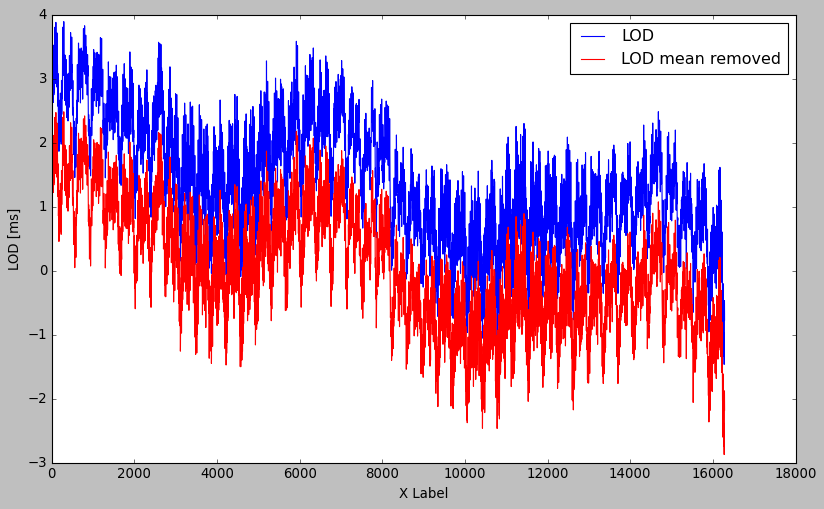

In [3]:
x = np.arange(len(datf))
sig = datf.LOD
plt.figure()
plt.plot(x,sig, c = 'b', label = 'LOD')
plt.xlabel('X Label')
plt.ylabel('LOD [ms]');
sig -= sig.mean()
plt.plot(x,sig, c= 'r', label = 'LOD mean removed')
plt.legend(loc="upper right");

## First let's see what frequencies are in the raw signal

First peak at cpy: 0.017 of value: 18.877
Second peak at cpy: 0.061 of value: 8.740
Third peak at cpy: 1.000 of value: 3.524


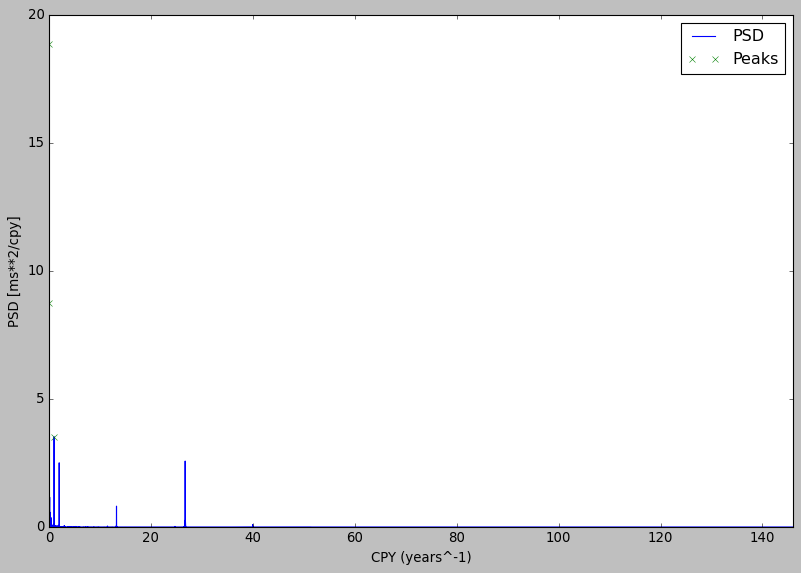

In [4]:
fs = 365 #sampling frequency is set to 365 samples per year
# so 1 cpy = 1 Hz (cpy = cycle per year)

#low pass filtering to nyquist frequncy to avoid frequency folding
cf = 0.4*fs #cut frequency in cpy
order = 2 #filter order
sos = signal.butter(order, cf, 'low', fs = fs, output = 'sos')
filtered_LB  = signal.sosfiltfilt(sos, sig)

#Periodogram generation
extrapad = 3; #extra padding for fft as a power of 2, fft length = 2^(next power of 2 (length data) + extrapad)
fftlen = 2**(math.ceil(math.log(len(sig))/math.log(2))+extrapad);
f, Pxx_den = signal.periodogram(filtered_LB, fs, nfft = fftlen)

#Peaks search
peaksidx, _ = signal.find_peaks(Pxx_den, distance=5)
peaks = np.flip(np.sort(Pxx_den[peaksidx]))[:3]
for i,t in zip(peaks,['First', 'Second', 'Third']):
    print('{} peak at cpy: {:.3f} of value: {:.3f}'.format(t, f[np.where(Pxx_den == i)][0], i))

#plot
fig, ax = plt.subplots(figsize=(12,8))
ax.plot(f[1:], Pxx_den[1:], label = 'PSD')
ax.plot([f[np.where(Pxx_den == pk)][0] for pk in peaks], peaks, "x", label = 'Peaks')        
ax.set_xlabel('CPY (years^-1)')
ax.set_ylabel('PSD [ms**2/cpy]')
ax.legend(loc=1)
ax.set_xlim([0, cf]);

## Let's focus on the low side of the spectrum

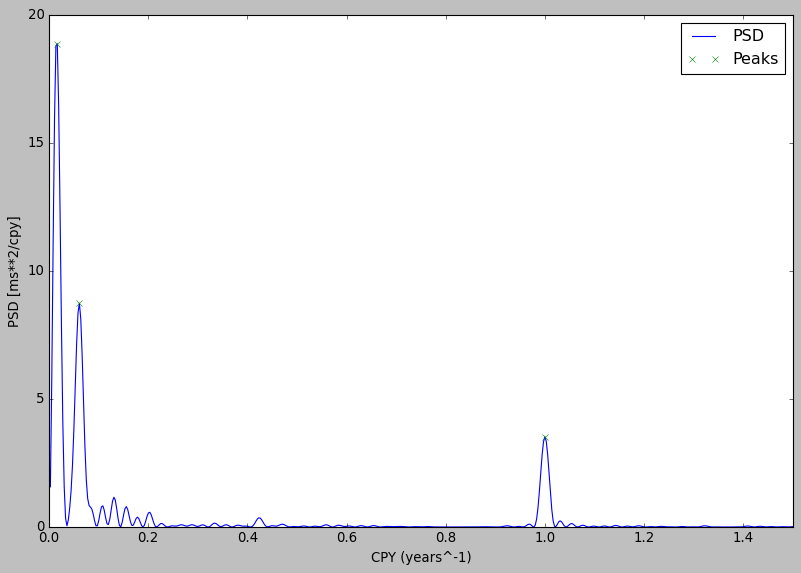

In [5]:
fig, ax = plt.subplots(figsize=(12,8))
ax.plot(f[1:], Pxx_den[1:], label = 'PSD')
ax.plot([f[np.where(Pxx_den == pk)][0] for pk in peaks], peaks, "x", label = 'Peaks')        
ax.set_xlabel('CPY (years^-1)')
ax.set_ylabel('PSD [ms**2/cpy]')
ax.legend(loc=1)
ax.set_xlim([0, 1.5]); #This restricts the x axis

## Same analysis can be done as a function of time using a spectrogram

(note the trade-off between frequency accuracy and time accuracy while varying the window length)

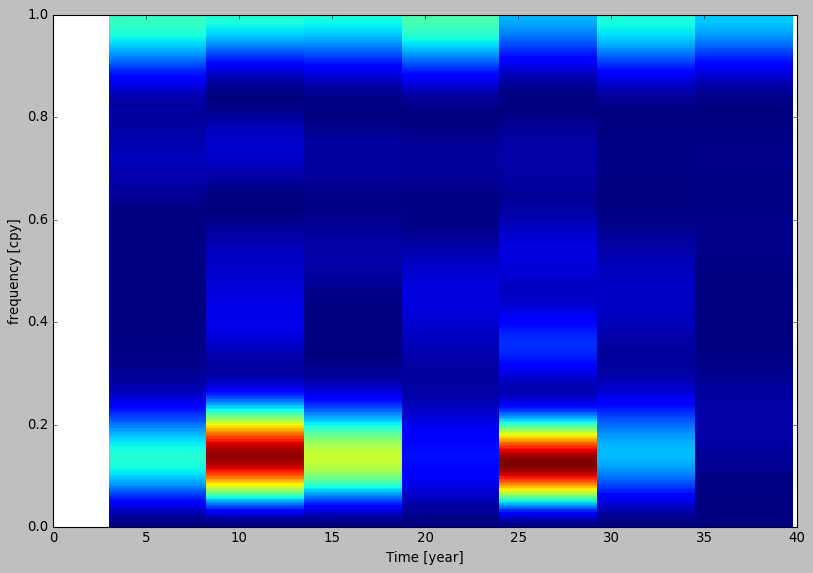

In [6]:
#low pass filtering to nyquist frequncy to avoid frequency folding
cf = 0.4*fs #cut frequency in cpy
order = 2 #filter order
sos = signal.butter(order, cf, 'low', fs = fs, output = 'sos')
filtered_LB  = signal.sosfiltfilt(sos, sig)

#Spectogram generation
winlen = 6*365 #window length for spectrogram
extrapad = 3; #extra padding for fft as a power of 2, fft length = 2^(next power of 2 (length data) + extrapad)
fftlen = 2**(math.ceil(math.log(len(filtered_LB))/math.log(2))+extrapad);

f, t, Sxx = signal.spectrogram(filtered_LB, fs,nperseg = winlen, nfft = fftlen )
fig, ax = plt.subplots(figsize=(12,8))
plt.pcolormesh(t, f, Sxx)
plt.ylabel('frequency [cpy]')
plt.xlabel('Time [year]')
plt.ylim([0, 1]);